In [10]:
#noahbrauer, edited by Stacey Hitchcock & Michael Hosek 2023
############# Function to convert to isentropic coordinates is courtesy of MetPy; Modifications made by Noah Brauer


import cartopy.crs as ccrs
import cartopy.feature as cfeature

import matplotlib.pyplot as plt
from netCDF4 import Dataset, num2date, MFDataset
import numpy as np
from datetime import datetime
from matplotlib.dates import YearLocator, MonthLocator, DateFormatter
from matplotlib.ticker import MultipleLocator
import xarray as xr
import metpy.calc as mpcalc
from metpy.cbook import get_test_data
from metpy.plots import add_metpy_logo, add_timestamp
from metpy.units import units

In [11]:
#List the files; YOU WILL NEED TO MODIFY THIS...

hgt_file = 'hgt.201102.nc'
temp_file = 'air.201102.nc'
q_file = 'shum.201102.nc'
u_file = 'uwnd.201102.nc'
v_file = 'vwnd.201102.nc'

#Read in each file 

nc_hgt = Dataset(hgt_file, 'r')
nc_temp = Dataset(temp_file, 'r')
nc_q = Dataset(q_file, 'r')
nc_u = Dataset(u_file, 'r')
nc_v = Dataset(v_file, 'r')


#Read in file attributes and extract times (Feb 19,2019 is what I'm pulling here)

lat = nc_hgt.variables['lat'][:]
lon = nc_hgt.variables['lon'][:] 

narr = {}
time = nc_hgt.variables['time'][:]
timeUnits = nc_hgt.variables['time'].units
tmpDates = num2date(time,timeUnits,calendar='gregorian')
narr['date'] = np.asarray([datetime(d.year,d.month,d.day) for d in tmpDates])
narr['day'] = np.asarray([d.day for d in narr['date']])
narr['month'] = np.asarray([d.month for d in narr['date']])
narr['year'] = np.asarray([d.year for d in narr['date']])

#Assign time index for our time of interest; YOU WILL HAVE TO CHANGE THIS LINE

time_index = np.where(narr['day']==2)[0]

#Now read in meteorological data for this day
level = nc_hgt.variables['level'][:] #In hPa
z = nc_hgt.variables['hgt'][time_index,:,:,:] #In meters
temp = nc_temp.variables['air'][time_index,:,:,:] #In Kelvin
q = nc_q.variables['shum'][time_index,:,:,:]
u = nc_u.variables['uwnd'][time_index,:,:,:]
v = nc_v.variables['vwnd'][time_index,:,:,:]


In [12]:
#Select your time of choice (03 UTC on 2/19 is the default now; YOU MAY NEED TO CHANGE THESE. Change the 1 to 2 if you want 06 UTC, etc.; times are in 3 hour increments)

temp = temp[0,:,:,:]
z = z[0,:,:,:]
q = q[0,:,:,:]
u = u[0,:,:,:]
v = v[0,:,:,:]

#Assign proper units to each variables
#Assign proper units to each variables
temp = units.Quantity(temp, "kelvin")
level = units.Quantity(level,"hectopascal")


#Define isentropic levels

isentlevs = [296.] * units.kelvin

#Now convert to isentropic coordinates

isentropic = mpcalc.isentropic_interpolation(isentlevs, level, temp, q, u, v, z, temperature_out=True)



#Separate variables (don't worry, this has nothing to do with PDEs)

isentprs, isenttmp, isentspech, isentu, isentv, isenthgt = isentropic


#Get q in units of g/kg

isentspec = isentspech*1000


#Convert m/s into knots for plotting


def ms_to_knot(wind):
    knots = wind/0.514
    return knots

u_knots = ms_to_knot(isentu)
v_knots = ms_to_knot(isentv)


#Calculate relative humidity from the specific humidity field; RH = spec_hum/saturation spec_hum * 100

isentspech=units.Quantity(isentspech, "g/kg")

isentrh = 100 * mpcalc.relative_humidity_from_specific_humidity(isentprs, isenttmp, isentspech)

isenthgt_m = units.Quantity(isenthgt, "m")

msf = mpcalc.montgomery_streamfunction(isenthgt_m, isenttmp) / 100
print(msf)




#NaN all values where longitude>0; This is an issue with NARR data...


rh_nan = np.ones((1,277,349))*np.nan
u_knots_nan = np.ones((1,277,349))*np.nan
v_knots_nan = np.ones((1,277,349))*np.nan
isentprs_nan = np.ones((1,277,349))*np.nan
isentspec_nan = np.ones((1,277,349))*np.nan #in kg/kg

for i in range(rh_nan.shape[1]):
    for j in range(rh_nan.shape[2]):
        
        if lon[i,j]>=0:
            rh_nan[:,i,j] = np.nan
            u_knots_nan[:,i,j] = np.nan
            v_knots_nan[:,i,j] = np.nan
            isentprs_nan[:,i,j] = np.nan
            isentspec_nan[:,i,j] = np.nan
            
        else:
            rh_nan[:,i,j] = isentrh[:,i,j]
            u_knots_nan[:,i,j] = u_knots[:,i,j]
            v_knots_nan[:,i,j] = v_knots[:,i,j]
            isentprs_nan[:,i,j] = isentprs[:,i,j]
            isentspec_nan[:,i,j] = isentspec[:,i,j]



    
print(np.nanmax(isentspec_nan))

z_m = units.Quantity(z, "m")

msf = mpcalc.montgomery_streamfunction(z_m, temp)

print(msf)
msf_2d = msf[0, :, :]

[[[-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  ...  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]]] kilojoule / kilogram
16.825479399383628
[[[298.63128662109375 298.6783752441406 298.73626708984375 ... -- -- --]  [298.6097106933594 298.6725158691406 298.73529052734375 ... -- -- --]  [298.60382080078125 298.6665954589844 298.7245178222656 ... -- -- --]  ...  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]] [[299.6337890625 299.6445617675781 299.6445617675781 ... -- -- --]  [299.6279296875 299.6387023925781 299.6387023925781 ... -- -- --]  [299.6376953125 299.6485290527344 299.6642150878906 ... -- -- --]  ...  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]] [[300.22613525390625 300.2418518066406 300.2575378417969 ... -- -- --]  [300.2359313964844 300.25164794921875 300.2359313964844 ... -- -- --]  [300.23004150390625 300.2457275390625 300.2614440917969 ... -- -- --]  ...  [-- -

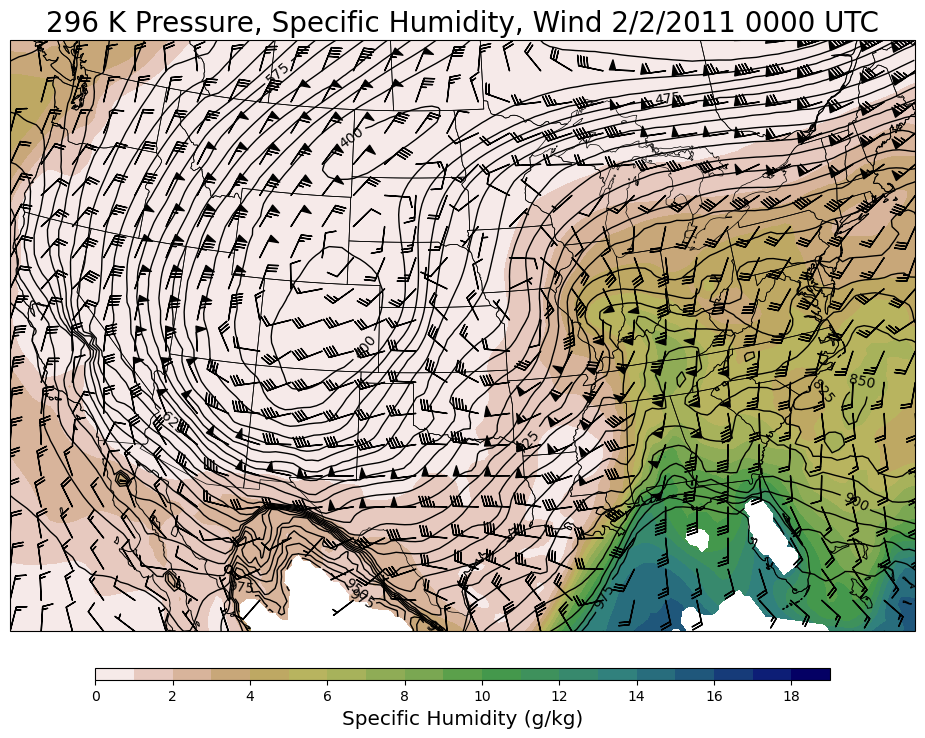

In [13]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Coordinates to limit map area
bounds = [(-120., -75., 25., 50.)]
# Choose a level to plot, in this case 296 K
level = 0

#Can tweak figure size if you would like
fig = plt.figure(figsize=(15., 8.))

ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot the surface
clevisent = np.arange(0, 1000, 25)
cs = ax.contour(lon, lat, isentprs_nan[level, :, :], clevisent,
                colors='k', linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot RH or specific humidity. 

#cf = ax.contourf(lon, lat, rh_nan[level, :, :], range(10, 106, 5), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, isentspec_nan[level, :, :], range(0,20, 1), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())


#Add a colorbar
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=0.5, pad=0.05,
                  extendrect='True')
cb.set_label('Specific Humidity (g/kg)', size='x-large')


#Plot wind barbs on the isentropic surface
ax.barbs(lon, lat, u_knots_nan[level, :, :], v_knots_nan[level, :, :], length=6,regrid_shape=20, transform=ccrs.PlateCarree())
# Make a title 
#print('Did you remember to change your title?')
plt.title('296 K Pressure, Specific Humidity, Wind 2/2/2011 0000 UTC', size = 20)
fig.tight_layout()
plt.show()

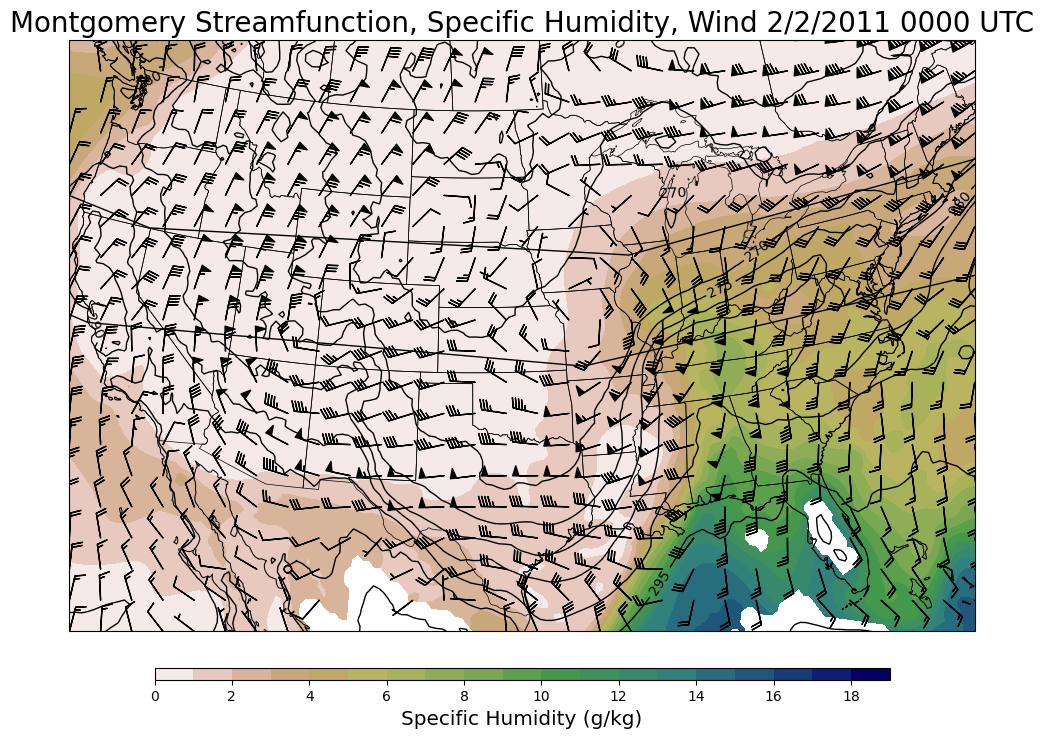

In [14]:
fig = plt.figure(figsize=(15., 8.))

ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

clevsmsf = np.arange(0, 4000, 5)
cs = ax.contour(lon, lat, msf_2d, colors='k', levels=clevsmsf, linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)


cf = ax.contourf(lon, lat, isentspec_nan[level, :, :], range(0,20, 1), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
#Add a colorbar
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=0.5, pad=0.05,
                  extendrect='True')
cb.set_label('Specific Humidity (g/kg)', size='x-large')


#Plot wind barbs on the isentropic surface
ax.barbs(lon, lat, u_knots_nan[level, :, :], v_knots_nan[level, :, :], length=6,regrid_shape=20, transform=ccrs.PlateCarree())
# Make a title 
#print('Did you remember to change your title?')
plt.title('Montgomery Streamfunction, Specific Humidity, Wind 2/2/2011 0000 UTC', size = 20)
fig.tight_layout()
plt.show()

In [15]:
#List the files; YOU WILL NEED TO MODIFY THIS...

hgt_file = 'hgt.201601.nc'
temp_file = 'air.201601.nc'
q_file = 'shum.201601.nc'
u_file = 'uwnd.201601.nc'
v_file = 'vwnd.201601.nc'

#Read in each file 

nc_hgt = Dataset(hgt_file, 'r')
nc_temp = Dataset(temp_file, 'r')
nc_q = Dataset(q_file, 'r')
nc_u = Dataset(u_file, 'r')
nc_v = Dataset(v_file, 'r')


#Read in file attributes and extract times (Feb 19,2019 is what I'm pulling here)

lat = nc_hgt.variables['lat'][:]
lon = nc_hgt.variables['lon'][:] 

narr = {}
time = nc_hgt.variables['time'][:]
timeUnits = nc_hgt.variables['time'].units
tmpDates = num2date(time,timeUnits,calendar='gregorian')
narr['date'] = np.asarray([datetime(d.year,d.month,d.day) for d in tmpDates])
narr['day'] = np.asarray([d.day for d in narr['date']])
narr['month'] = np.asarray([d.month for d in narr['date']])
narr['year'] = np.asarray([d.year for d in narr['date']])

#Assign time index for our time of interest; YOU WILL HAVE TO CHANGE THIS LINE

time_index = np.where(narr['day']==22)[0]

#Now read in meteorological data for this day
level = nc_hgt.variables['level'][:] #In hPa
z = nc_hgt.variables['hgt'][time_index,:,:,:] #In meters
temp = nc_temp.variables['air'][time_index,:,:,:] #In Kelvin
q = nc_q.variables['shum'][time_index,:,:,:]
u = nc_u.variables['uwnd'][time_index,:,:,:]
v = nc_v.variables['vwnd'][time_index,:,:,:]

In [16]:
#Select your time of choice (03 UTC on 2/19 is the default now; YOU MAY NEED TO CHANGE THESE. Change the 1 to 2 if you want 06 UTC, etc.; times are in 3 hour increments)

temp = temp[4,:,:,:]
z = z[4,:,:,:]
q = q[4,:,:,:]
u = u[4,:,:,:]
v = v[4,:,:,:]

#Assign proper units to each variables
#Assign proper units to each variables
temp = units.Quantity(temp, "kelvin")
level = units.Quantity(level,"hectopascal")


#Define isentropic levels

isentlevs = [296.] * units.kelvin

#Now convert to isentropic coordinates

isentropic = mpcalc.isentropic_interpolation(isentlevs, level, temp, q, u, v, z, temperature_out=True)



#Separate variables (don't worry, this has nothing to do with PDEs)

isentprs, isenttmp, isentspech, isentu, isentv, isenthgt = isentropic


#Get q in units of g/kg

isentspec = isentspech*1000


#Convert m/s into knots for plotting


def ms_to_knot(wind):
    knots = wind/0.514
    return knots

u_knots = ms_to_knot(isentu)
v_knots = ms_to_knot(isentv)


#Calculate relative humidity from the specific humidity field; RH = spec_hum/saturation spec_hum * 100

isentspech=units.Quantity(isentspech, "g/kg")

isentrh = 100 * mpcalc.relative_humidity_from_specific_humidity(isentprs, isenttmp, isentspech)






#NaN all values where longitude>0; This is an issue with NARR data...


rh_nan = np.ones((1,277,349))*np.nan
u_knots_nan = np.ones((1,277,349))*np.nan
v_knots_nan = np.ones((1,277,349))*np.nan
isentprs_nan = np.ones((1,277,349))*np.nan
isentspec_nan = np.ones((1,277,349))*np.nan #in kg/kg

for i in range(rh_nan.shape[1]):
    for j in range(rh_nan.shape[2]):
        
        if lon[i,j]>=0:
            rh_nan[:,i,j] = np.nan
            u_knots_nan[:,i,j] = np.nan
            v_knots_nan[:,i,j] = np.nan
            isentprs_nan[:,i,j] = np.nan
            isentspec_nan[:,i,j] = np.nan
            
        else:
            rh_nan[:,i,j] = isentrh[:,i,j]
            u_knots_nan[:,i,j] = u_knots[:,i,j]
            v_knots_nan[:,i,j] = v_knots[:,i,j]
            isentprs_nan[:,i,j] = isentprs[:,i,j]
            isentspec_nan[:,i,j] = isentspec[:,i,j]



    
print(np.nanmax(isentspec_nan))

C:\Users\Tony\anaconda3\lib\site-packages\metpy\interpolate\one_dimension.py:137: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')
C:\Users\Tony\anaconda3\lib\site-packages\metpy\interpolate\one_dimension.py:147: UserWarning: Interpolation point out of data bounds encountered
  warnings.warn('Interpolation point out of data bounds encountered')


16.45815157771196


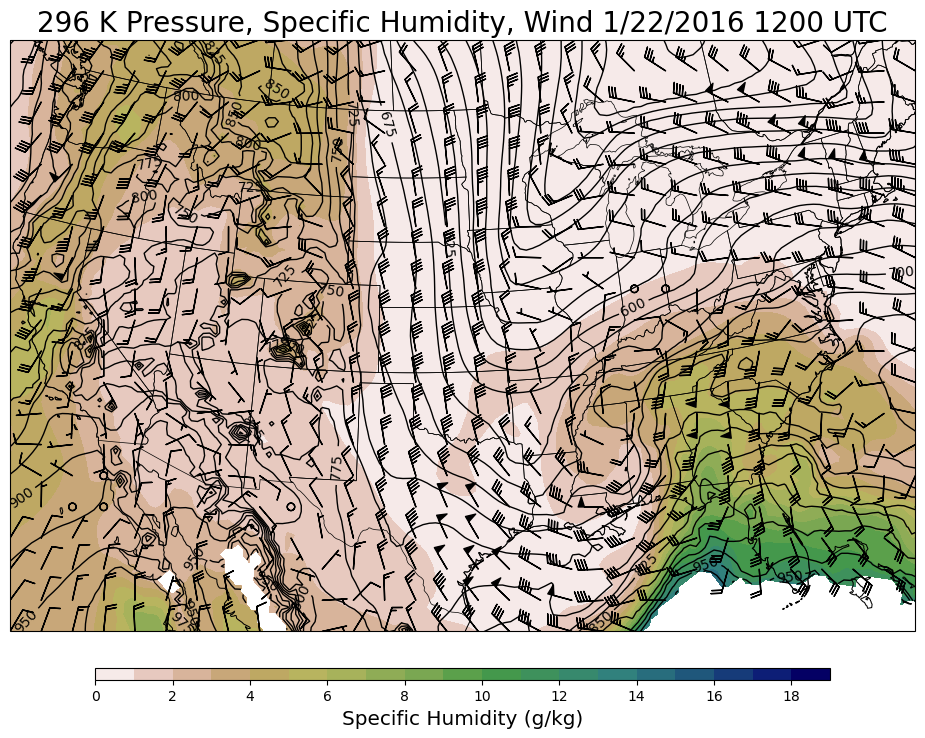

In [17]:
# Set up our projection
crs = ccrs.LambertConformal(central_longitude=-100.0, central_latitude=45.0)

# Coordinates to limit map area
bounds = [(-120., -75., 25., 50.)]
# Choose a level to plot, in this case 296 K
level = 0

#Can tweak figure size if you would like
fig = plt.figure(figsize=(15., 8.))

ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

# Plot the surface
clevisent = np.arange(0, 1000, 25)
cs = ax.contour(lon, lat, isentprs_nan[level, :, :], clevisent,
                colors='k', linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)

# Plot RH or specific humidity. 

#cf = ax.contourf(lon, lat, rh_nan[level, :, :], range(10, 106, 5), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
cf = ax.contourf(lon, lat, isentspec_nan[level, :, :], range(0,20, 1), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())


#Add a colorbar
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=0.5, pad=0.05,
                  extendrect='True')
cb.set_label('Specific Humidity (g/kg)', size='x-large')


#Plot wind barbs on the isentropic surface
ax.barbs(lon, lat, u_knots_nan[level, :, :], v_knots_nan[level, :, :], length=6,regrid_shape=20, transform=ccrs.PlateCarree())
# Make a title 
#print('Did you remember to change your title?')
plt.title('296 K Pressure, Specific Humidity, Wind 1/22/2016 1200 UTC', size = 20)
fig.tight_layout()
plt.show()

C:\Users\Tony\anaconda3\lib\site-packages\numpy\ma\core.py:1020: RuntimeWarning: overflow encountered in multiply
  result = self.f(da, db, *args, **kwargs)


[[[298.47796630859375 297.1789245605469 295.9848937988281 ... -- -- --]  [298.09429931640625 296.49212646484375 294.9890441894531 ... -- -- --]  [297.9726257324219 296.1085205078125 294.5376892089844 ... -- -- --]  ...  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]] [[298.1449890136719 296.9254455566406 295.91485595703125 ... -- -- --]  [297.787841796875 296.2494201660156 294.9720153808594 ... -- -- --]  [297.6661682128906 295.91778564453125 294.8974609375 ... -- -- --]  ...  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]] [[299.148681640625 299.3949279785156 299.8285827636719 ... -- -- --]  [299.0220947265625 299.1270751953125 299.885498046875 ... -- -- --]  [298.77484130859375 298.8955078125 299.4655456542969 ... -- -- --]  ...  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]  [-- -- -- ... -- -- --]] ... [[349.47943115234375 349.3950500488281 349.3057556152344 ... -- -- --]  [349.3165588378906 349.22235107421875 349.11740112304

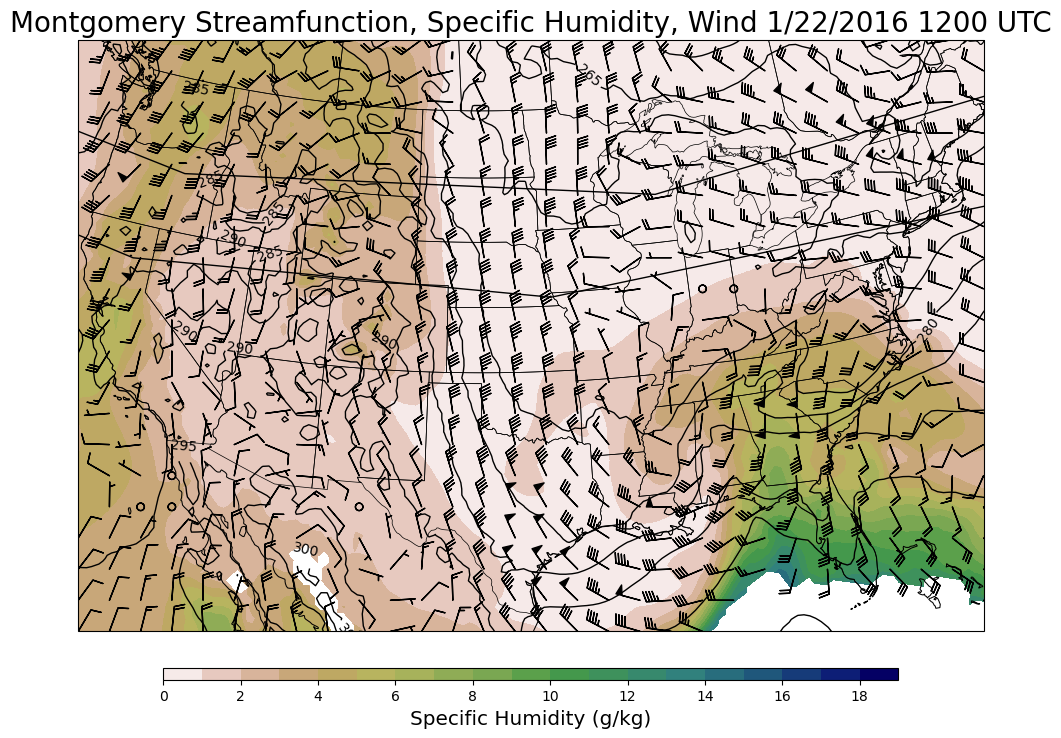

In [18]:
z_m = units.Quantity(z, "m")

msf = mpcalc.montgomery_streamfunction(z_m, temp)

print(msf)
msf_2d = msf[0, :, :]

fig = plt.figure(figsize=(15., 8.))

ax = fig.add_subplot(1, 1, 1, projection=crs)
ax.set_extent(*bounds, crs=ccrs.PlateCarree())
ax.add_feature(cfeature.COASTLINE.with_scale('50m'), linewidth=0.75)
ax.add_feature(cfeature.STATES, linewidth=0.5)

clevsmsf = np.arange(0, 4000, 5)
cs = ax.contour(lon, lat, msf_2d, colors='k', levels=clevsmsf, linewidths=1.0, linestyles='solid', transform=ccrs.PlateCarree())
ax.clabel(cs, fontsize=10, inline=1, inline_spacing=7,
          fmt='%i', rightside_up=True, use_clabeltext=True)


cf = ax.contourf(lon, lat, isentspec_nan[level, :, :], range(0,20, 1), cmap=plt.cm.gist_earth_r, transform=ccrs.PlateCarree())
#Add a colorbar
cb = fig.colorbar(cf, orientation='horizontal', extend='max', aspect=65, shrink=0.5, pad=0.05,
                  extendrect='True')
cb.set_label('Specific Humidity (g/kg)', size='x-large')


#Plot wind barbs on the isentropic surface
ax.barbs(lon, lat, u_knots_nan[level, :, :], v_knots_nan[level, :, :], length=6,regrid_shape=20, transform=ccrs.PlateCarree())
# Make a title 
#print('Did you remember to change your title?')
plt.title('Montgomery Streamfunction, Specific Humidity, Wind 1/22/2016 1200 UTC', size = 20)
fig.tight_layout()
plt.show()